# Collect data

## Load packages

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.io
import anndata
import scanpy as sc
from networkx.algorithms.bipartite import biadjacency_matrix
from matplotlib import rcParams
import matplotlib.pyplot as plt

import scglue

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ignite.handlers.checkpoint")

In [3]:
# IMPORTANT if Bedtools cannot be found automatically
scglue.config.BEDTOOLS_PATH = '/usr/local/bin'
# conda_version: '/root/miniconda3/envs/myconda/bin/bedtools'
# binary_version: '/mnt/CMML3_Mini_Project2/pkgs', '/usr/local/bin'

In [4]:
scglue.__version__

'0.3.0'

In [5]:
scglue.config.BEDTOOLS_PATH

'/usr/local/bin'

## scRNA-seq

### Read data

In [6]:
rna_matrix = scipy.io.mmread("../data/GSE126074/RNA/matrix.mtx.gz").T.tocsr()
rna_obs = pd.read_csv("../data/GSE126074/RNA/barcodes.tsv.gz", header=None, index_col=0)
rna_var = pd.read_csv("../data/GSE126074/RNA/features.tsv.gz", header=None, index_col=0)
rna_obs.index.name, rna_var.index.name = "cells", "genes"
rna = anndata.AnnData(X=rna_matrix, obs=rna_obs, var=rna_var)
rna

AnnData object with n_obs × n_vars = 10309 × 33160

### Process meta

In [7]:
rna.obs["domain"] = "scRNA-seq"
rna.obs["protocol"] = "SNARE-seq"
rna.obs["dataset"] = "GSE126074-RNA"

In [8]:
scglue.data.get_gene_annotation(
    rna, gtf="../data/genome/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var["genome"] = "mm10"

## scATAC-seq

### Read data

In [9]:
atac_matrix = scipy.io.mmread("../data/GSE126074/ATAC/matrix.mtx.gz").T.tocsr()
atac_obs = pd.read_csv("../data/GSE126074/ATAC/barcodes.tsv.gz", header=None, index_col=0)
atac_var = pd.read_csv("../data/GSE126074/ATAC/features.tsv.gz", header=None, index_col=0)
atac_obs.index.name, atac_var.index.name = "cells", "peaks"
atac = anndata.AnnData(X=atac_matrix, obs=atac_obs, var=atac_var)
atac

AnnData object with n_obs × n_vars = 10309 × 244544

### Process meta

In [10]:
atac.obs["domain"] = "scATAC-seq"
atac.obs["protocol"] = "SNARE-seq"
atac.obs["dataset"] = "GSE126074-ATAC"

In [11]:
atac.var["chrom"] = np.vectorize(lambda x: x.split(":")[0])(atac.var_names)
atac.var["chromStart"] = np.vectorize(lambda x: x.split(":")[1].split("-")[0])(atac.var_names).astype(int)
atac.var["chromEnd"] = np.vectorize(lambda x: x.split("-")[1])(atac.var_names).astype(int)
atac.var["genome"] = "mm10"

## Pair samples & add cell types

In [12]:
meta = pd.read_csv("../data/GSE126074/metadata.csv", index_col=0)
meta = meta.query("Ident != 'Mis'")
meta.head()

,Batch,Barcode,Ident
09A_CAGCCCCGCCTT,09A,CAGCCCCGCCTT,E3Rorb
09A_CGCCTACCATGA,09A,CGCCTACCATGA,E5Parm1
09A_GATGCGCGGCTA,09A,GATGCGCGGCTA,Ast
09A_GGTCCGAGTCCT,09A,GGTCCGAGTCCT,E4Il1rapl2
09A_TCTCCCGGCACC,09A,TCTCCCGGCACC,E5Parm1


In [13]:
rna = rna[meta.index, :]
atac = atac[meta.index, :]

In [14]:
rna.obs["cell_type"] = meta["Ident"]
atac.obs["cell_type"] = meta["Ident"]

/tmp/ipykernel_17548/2142625384.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs["cell_type"] = meta["Ident"]
/tmp/ipykernel_17548/2142625384.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atac.obs["cell_type"] = meta["Ident"]


## Clean data

In [15]:
retained_genes = rna.var.dropna(subset=["chrom", "chromStart", "chromEnd"]).index
rna = rna[:, retained_genes]
rna.var = rna.var.astype({"chromStart": int, "chromEnd": int})
rna

AnnData object with n_obs × n_vars = 9190 × 30857
    obs: 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome'

In [16]:
sc.pp.filter_genes(rna, min_counts=1)
rna

AnnData object with n_obs × n_vars = 9190 × 28930
    obs: 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome', 'n_counts'

In [17]:
import pybedtools
blacklist_overlap = scglue.genomics.window_graph(
    scglue.genomics.Bed(atac.var.assign(name=atac.var_names)),
    "../data/genome/Blacklist/mm10-blacklist.v2.bed.gz",
    window_size=0
)

window_graph:   0%|          | 0/244544 [00:00<?, ?it/s]

In [18]:
retained_peaks = np.asarray(biadjacency_matrix(
    blacklist_overlap, atac.var_names
).sum(axis=1)).ravel() == 0
atac = atac[:, retained_peaks]
atac.var = atac.var.astype({"chromStart": int, "chromEnd": int})
atac

AnnData object with n_obs × n_vars = 9190 × 241925
    obs: 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'genome'

In [19]:
sc.pp.filter_genes(atac, min_counts=1)
atac

AnnData object with n_obs × n_vars = 9190 × 241757
    obs: 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'genome', 'n_counts'

## Save data

In [20]:
rna.write("../data/GSE126074/GSE126074-RNA.h5ad", compression="gzip")
atac.write("../data/GSE126074/GSE126074-ATAC.h5ad", compression="gzip")
!touch ../data/GSE126074/GSE126074-FRAGS2RNA.h5ad  # Sham file

# Preprocess data

In [21]:
rna = anndata.read_h5ad("../data/GSE126074/GSE126074-RNA.h5ad")
atac = anndata.read_h5ad("../data/GSE126074/GSE126074-ATAC.h5ad")

In [22]:
# set presentation interface
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## RNA preprocessing

In [23]:
# check RNA data
rna, rna.X, rna.X.data

(AnnData object with n_obs × n_vars = 9190 × 28930
     obs: 'domain', 'protocol', 'dataset', 'cell_type'
     var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome', 'n_counts',
 <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 8633857 stored elements and shape (9190, 28930)>,
 array([1, 1, 1, ..., 3, 1, 1]))

In [24]:
# back up the raw UMI counts in a layer called “counts”
rna.layers["counts"] = rna.X.copy()

2025-05-26 20:33:44.625366: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 20:33:44.631059: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 20:33:44.641391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748262824.658665   17548 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748262824.663672   17548 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

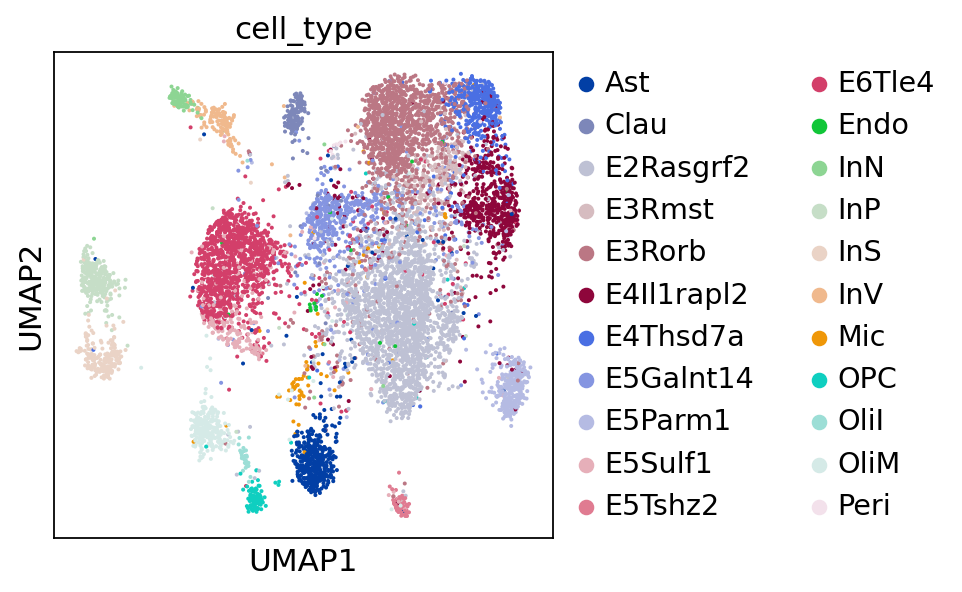

CPU times: user 53.8 s, sys: 3 s, total: 56.8 s
Wall time: 51.9 s


In [25]:
%%time
# first up use the “seurat_v3” method to select 2,000 highly variable genes.
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

# normalization and scale + PCA reducing dimensionality
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")
          
# UMAP
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

## ATAC preprocessing

In [26]:
# check ATAC data
atac, atac.X, atac.X.data

(AnnData object with n_obs × n_vars = 9190 × 241757
     obs: 'domain', 'protocol', 'dataset', 'cell_type'
     var: 'chrom', 'chromStart', 'chromEnd', 'genome', 'n_counts',
 <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 22575391 stored elements and shape (9190, 241757)>,
 array([2, 1, 1, ..., 1, 1, 1]))

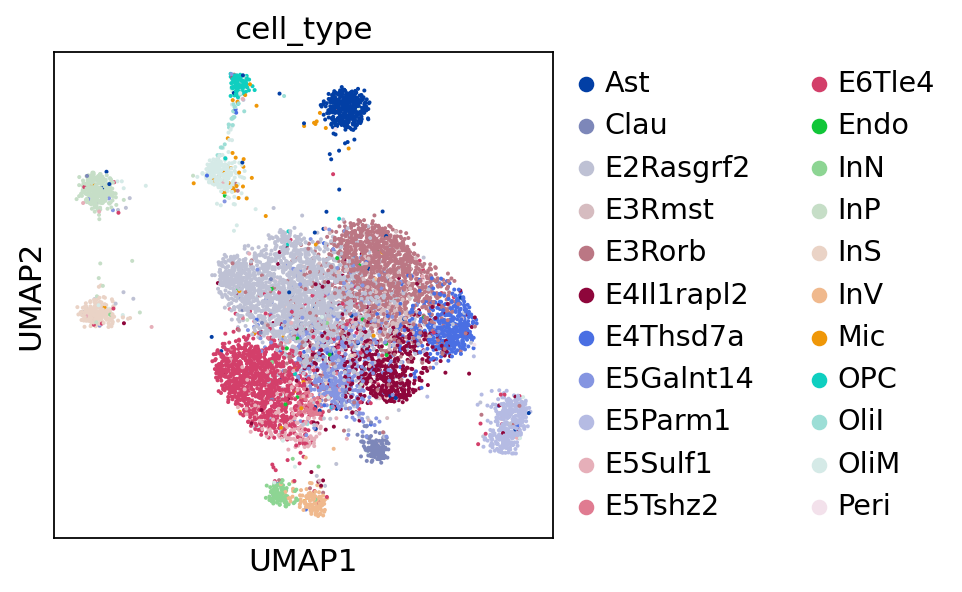

CPU times: user 2min 24s, sys: 2.46 s, total: 2min 26s
Wall time: 2min 10s


In [27]:
%%time
# Reduce dimensionality with LSI
scglue.data.lsi(atac, n_components=100, n_iter=15)

# UMAP
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.pl.umap(atac, color="cell_type")

In [28]:
# Save data preprocessing results
# CAUTIOUS! Might lead to disc quota exceeding.
rna.write_h5ad("../data/GSE126074/GSE126074-RNA_pp.h5ad")
atac.write_h5ad("../data/GSE126074/GSE126074-ATAC_pp.h5ad")